# Feature Multiplicity in SAEs

In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from transformer_lens import HookedTransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
)
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
hf_cache = os.environ.get("HF_HOME", None)
print(f"Using Hugging Face cache directory: {hf_cache}")

Using device: cuda
Using Hugging Face cache directory: /work/pi_jensen_umass_edu/svaidyanatha_umass_edu/huggingface


In [10]:
# Load the model
model_name = "google/gemma-2-2b"  # Replace with the desired model name
print(f"Loading model: {model_name}...")
model = HookedSAETransformer.from_pretrained(model_name, device=device, cache_dir=hf_cache)

Loading model: google/gemma-2-2b...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


# IOI demo for reference

In [28]:
prompts = [
    "Cuando John y Mary fueron a las tiendas, John le dio la bolsa a",
    "Cuando John y Mary fueron a las tiendas, Mary le dio la bolsa a",
    "Cuando Tom y James fueron al parque, James le dio la pelota a",
    "Cuando Tom y James fueron al parque, Tom le dio la pelota a",
    "Cuando Dan y Sid fueron a las tiendas, Sid le dio una manzana a",
    "Cuando Dan y Sid fueron a las tiendas, Dan le dio una manzana a",
    "Después de que Martin y Amy fueron al parque, Amy le dio una bebida a",
    "Después de que Martin y Amy fueron al parque, Martin le dio una bebida a"
]

answers = [(' Mary', ' John'), (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
print("Answer token indices", answer_token_indices)

# Print answers by decoding answer token
answer_tokens = model.tokenizer.decode(answer_token_indices.flatten().tolist())
print("Answers", answer_tokens)

def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

# Print next token prediction for clean and corrupted strings 0


Clean string 0 <bos>Cuando John y Mary fueron a las tiendas, John le dio la bolsa a<pad>
Corrupted string 0 <bos>Cuando John y Mary fueron a las tiendas, Mary le dio la bolsa a<pad>
Answer token indices tensor([[ 7473,  3350],
        [ 3350,  7473],
        [ 6738,  6110],
        [ 6110,  6738],
        [ 4828, 26452],
        [26452,  4828],
        [ 9510, 27161],
        [27161,  9510]], device='cuda:0')
Answers  Mary John John Mary Tom James James Tom Dan Sid Sid Dan Martin Amy Amy Martin
Clean logit diff: 3.7741
Corrupted logit diff: -3.7741
Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


# Tutorial for reference

In this section, we're going to have a look at our SAEs, and see what they're actually telling us.

Before we dive too deep however, let's recap something - what actually is an SAE latent?

An SAE latent is a particular direction** in the base model's activation space, learned by the SAE. Often, these correspond to **features** in the data - in other words, meaningful semantic, syntactic or otherwise interpretable patterns or concepts that exist in the distribution of data the base model was trained on, and which were learned by the base model. These features are usually highly sparse, in other words for any given feature only a small fraction of the overall data distribution will activate that feature. It tends to be the case that sparser features are also more interpretable.

**Note - technically saying "direction" is an oversimplification here, because a given latent can have multiple directions in activation space associated with them, e.g. a separate encoder and decoder direction for standard untied SAEs. When we refer to a latent direction or feature direction, we're usually but not always referring to the decoder weights.

The dashboard shown below provides a detailed view of a single SAE latent. Let's break down the separate components of the visualization:

1. **Latent Activation Distribution**. This shows the proportion of tokens a latent fires on, usually between 0.01% and 1%, and also shows the distribution of positive activations.  
2. **Logits Distribution**. This is the projection of the decoder weight onto the unembed and roughly gives us a sense of the tokens promoted by a latent. It's less useful in big models / middle layers.
3. **Top / Botomn Logits**. These are the 10 most positive and most negative logits in the logit weight distribution.
4. **Max Activating Examples**. These are examples of text where the latent fires and usually provide the most information for helping us work out what a latent means.
5. **Autointerp**. These are LLM-generated latent explanations, which use the rest of the data in the dashboard (in particular the max activating examples).

See this section of [Towards Monosemanticity](https://transformer-circuits.pub/2023/monosemantic-features#setup-interface) for more information.

*Neuronpedia* is a website that hosts SAE dashboards and which runs servers that can run the model and check latent activations. This makes it very convenient to check that a latent fires on the distribution of text you actually think it should fire on. We've been downloading data from Neuronpedia for the dashboards above.

In [18]:
from IPython.display import IFrame, display
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

def display_dashboard(
    sae_release="gemma-scope-2b-pt-res-canonical",
    sae_id="layer_14/width_16k/canonical",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))


latent_idx = 13
display_dashboard(latent_idx=latent_idx)

https://neuronpedia.org/gemma-2-2b/14-gemmascope-res-16k/13?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Now that we've had a look at some SAEs via Neuronpedia, it's time to load them in and start running them ourselves!

One of the key features of `HookedSAETransformer` is being able to "splice in" SAEs, replacing model activations with their SAE reconstructions. To run a forward pass with SAEs attached, you can use `model.run_with_saes(tokens, saes=[list_of_saes])`. This function has similar syntax to the standard forward pass (or to `model.run_with_hooks`), e.g. it can take arguments like `return_type` to specify whether the return type should be loss or logits. The attached SAEs will be reset immediately after the forward pass, returning the model to its original state. Under the hood, they work just like adding hooks in TransformerLens, only in this case our hooks are "replace these activations with their SAE reconstructions".

There are a lot of other ways you can do SAE-hooked forward passes, which parallel the multiple way you can do regular hooked forward passes. For example, just like you can use `with model.hooks(fwd_hooks=...)` as a context manager to add hooks temporarily, you can also use `with model.saes(saes=...)` to run a forward pass with SAEs attached. And just like you can use `model.add_hook` and `model.reset_hooks`, you can also use `model.add_sae` and `model.reset_saes`.

In [21]:
from transformer_lens.utils import test_prompt

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res-canonical",
    sae_id="layer_14/width_16k/canonical",
    device=str(device),
)

prompt = "When John and Mary went to the shops, John gave the bag to"
answer = " Mary"

# First see how the model does without SAEs
test_prompt(prompt, answer, model)

# Test our prompt, to see what the model says
with model.saes(saes=[sae]):
    test_prompt(prompt, answer, model)

# Same thing, done in a different way
model.add_sae(sae)
test_prompt(prompt, answer, model)
model.reset_saes()  # Remember to always do this!

# Using `run_with_saes` method in place of standard forward pass
logits = model(prompt, return_type="logits")
logits_sae = model.run_with_saes(prompt, saes=[sae], return_type="logits")
answer_token_id = model.to_single_token(answer)

# Getting model's prediction
top_prob, token_id_prediction = logits[0, -1].softmax(-1).max(-1)
top_prob_sae, token_id_prediction_sae = logits_sae[0, -1].softmax(-1).max(-1)

print(f"""Standard model: top prediction = {model.to_string(token_id_prediction)!r}, prob = {top_prob.item():.2%}
SAE reconstruction: top prediction = {model.to_string(token_id_prediction_sae)!r}, prob = {top_prob_sae.item():.2%}
""")

Tokenized prompt: ['<bos>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 28.06 Prob: 67.14% Token: | Mary|

Top 0th token. Logit: 28.06 Prob: 67.14% Token: | Mary|
Top 1th token. Logit: 26.70 Prob: 17.18% Token: | the|
Top 2th token. Logit: 25.47 Prob:  5.02% Token: | his|
Top 3th token. Logit: 24.47 Prob:  1.85% Token: | a|
Top 4th token. Logit: 24.20 Prob:  1.41% Token: | John|
Top 5th token. Logit: 22.98 Prob:  0.42% Token: | Mrs|
Top 6th token. Logit: 22.70 Prob:  0.31% Token: | her|
Top 7th token. Logit: 22.61 Prob:  0.29% Token: | mary|
Top 8th token. Logit: 22.59 Prob:  0.28% Token: | their|
Top 9th token. Logit: 22.56 Prob:  0.27% Token: | Maria|


Ranks of the answer tokens: [(' Mary', 0)]

Tokenized prompt: ['<bos>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 28.74 Prob: 77.43% Token: | Mary|

Top 0th token. Logit: 28.74 Prob: 77.43% Token: | Mary|
Top 1th token. Logit: 27.02 Prob: 13.97% Token: | the|
Top 2th token. Logit: 25.40 Prob:  2.74% Token: | his|
Top 3th token. Logit: 24.90 Prob:  1.67% Token: | John|
Top 4th token. Logit: 23.49 Prob:  0.41% Token: | a|
Top 5th token. Logit: 23.02 Prob:  0.26% Token: | her|
Top 6th token. Logit: 22.83 Prob:  0.21% Token: |Mary|
Top 7th token. Logit: 22.65 Prob:  0.18% Token: | mary|
Top 8th token. Logit: 22.53 Prob:  0.16% Token: | give|
Top 9th token. Logit: 22.41 Prob:  0.14% Token: |mary|


Ranks of the answer tokens: [(' Mary', 0)]

Tokenized prompt: ['<bos>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 28.74 Prob: 77.43% Token: | Mary|

Top 0th token. Logit: 28.74 Prob: 77.43% Token: | Mary|
Top 1th token. Logit: 27.02 Prob: 13.97% Token: | the|
Top 2th token. Logit: 25.40 Prob:  2.74% Token: | his|
Top 3th token. Logit: 24.90 Prob:  1.67% Token: | John|
Top 4th token. Logit: 23.49 Prob:  0.41% Token: | a|
Top 5th token. Logit: 23.02 Prob:  0.26% Token: | her|
Top 6th token. Logit: 22.83 Prob:  0.21% Token: |Mary|
Top 7th token. Logit: 22.65 Prob:  0.18% Token: | mary|
Top 8th token. Logit: 22.53 Prob:  0.16% Token: | give|
Top 9th token. Logit: 22.41 Prob:  0.14% Token: |mary|


Ranks of the answer tokens: [(' Mary', 0)]

Standard model: top prediction = ' Mary', prob = 67.14%
SAE reconstruction: top prediction = ' Mary', prob = 77.43%



Okay, so this is fine if we want to do a forward pass with the model's output replaced by SAE output, but what if we want to just get the SAE activations? Well, that's where running with cache comes in! With `HookedSAETransformer`, you can cache SAE activations (and all the other standard activations) with `logits, cache = model.run_with_cache_with_saes(tokens, saes=saes)`. Just as `run_with_saes` is a wapper around the standard forward pass, `run_with_cache_with_saes` is a wrapper around `run_with_cache`, and will also only add these saes for one forward pass before returning the model to its original state.

To access SAE activations from the cache, the corresponding hook names will generally be the concatenations of the HookedTransformer `hook_name` (e.g. `"blocks.5.attn.hook_z"`) and the SAE hook name (e.g. `"hook_sae_acts_post"`), joined by a period. We can print out all the names below:

In [22]:
_, cache = model.run_with_cache_with_saes(prompt, saes=[sae])

for name, param in cache.items():
    if "hook_sae" in name:
        print(f"{name:<43}: {tuple(param.shape)}")

blocks.14.hook_resid_post.hook_sae_input   : (1, 15, 2304)
blocks.14.hook_resid_post.hook_sae_acts_pre: (1, 15, 16384)
blocks.14.hook_resid_post.hook_sae_acts_post: (1, 15, 16384)
blocks.14.hook_resid_post.hook_sae_recons  : (1, 15, 2304)
blocks.14.hook_resid_post.hook_sae_output  : (1, 15, 2304)


`run_with_cache_with_saes` makes it easy to explore which SAE latents are active across any input. We can also use this along with the argument `stop_at_layer` in our forward pass, because we don't need to compute any activations past the SAE layer.

Let's explore the active latents at the final token in our prompt. You should find that the first latent fires on the word "to".

In [23]:
import plotly.express as px

# Get top activations on final token
_, cache = model.run_with_cache_with_saes(
    prompt,
    saes=[sae],
    stop_at_layer=sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]

# Plot line chart of latent activations
px.line(
    sae_acts_post.cpu().numpy(),
    title=f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)",
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
).update_layout(showlegend=False).show()

# Print the top 5 latents, and inspect their dashboards
for act, ind in zip(*sae_acts_post.topk(3)):
    print(f"Latent {ind} had activation {act:.2f}")
    display_dashboard(latent_idx=ind)

Latent 12319 had activation 29.22
https://neuronpedia.org/gemma-2-2b/14-gemmascope-res-16k/12319?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 8937 had activation 27.50
https://neuronpedia.org/gemma-2-2b/14-gemmascope-res-16k/8937?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 5835 had activation 20.09
https://neuronpedia.org/gemma-2-2b/14-gemmascope-res-16k/5835?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [26]:
logits_no_saes, cache_no_saes = model.run_with_cache(prompt)

sae.use_error_term = False
logits_with_sae_recon, cache_with_sae_recon = model.run_with_cache_with_saes(prompt, saes=[sae])

sae.use_error_term = True
logits_without_sae_recon, cache_without_sae_recon = model.run_with_cache_with_saes(prompt, saes=[sae])

# Both SAE caches contain the hook values
assert f"{sae.cfg.hook_name}.hook_sae_acts_post" in cache_with_sae_recon
assert f"{sae.cfg.hook_name}.hook_sae_acts_post" in cache_without_sae_recon

# But the final output will be different, because we don't use SAE reconstructions when use_error_term=True
# torch.testing.assert_close(logits_no_saes, logits_without_sae_recon)
logit_diff_from_sae = (logits_no_saes - logits_with_sae_recon).abs().mean()
print(f"Average logit diff from using SAE reconstruction: {logit_diff_from_sae:.4f}")

Average logit diff from using SAE reconstruction: 3.6612


# Circuits by masking

In [29]:
layers= [5, 10, 15, 20]
saes = [SAE.from_pretrained(release="gemma-scope-2b-pt-res-canonical", sae_id=f"layer_{layers[i]}/width_16k/canonical", device=device)[0] for i in range(len(layers))]

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [30]:
# Set pad_token_id and freeze model parameters
pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
    param.requires_grad_(False)

print("Model loaded and parameters frozen.")

Model loaded and parameters frozen.


In [31]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    for param in model.parameters():
        param.grad = None
    cleanup_cuda()

In [32]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents

class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation


        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        # mask = self.mask
        self.sparsity_loss = torch.abs(mask).sum() * self.l1
        # print("hello", torch.abs(mask).sum())
        # if len(mask.shape) == 2:
        #     self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.distinct_l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()

        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}

    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()

def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()

def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)

    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [33]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,

    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,

    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,

    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()

        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()

        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)

        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook

def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

In [35]:
# Define dropdown for task selection
dropdown = "sva/rc"  # @param ["sva/rc", "codereason/key/len5_digit1", "codereason/index/len6_digit1", "ioi/baba21"]

# Define the task configurations
tasks = {
    "sva/rc": {"file_path": "data/rc_train.json", "example_length": 7},
    "codereason/key/len5_digit1": {
        "file_path": "data/codereason/index/data_len5_digit1_errOnly_output.json",
        "example_length": 24,
    },
    "codereason/index/len6_digit1": {
        "file_path": "data/codereason/key/data_len5_digit1.json",
        "example_length": 41,
    },
    "ioi/baba21": {
        "file_path": "data/custom_task.json",  # Replace with the actual file path
        "example_length": 10,  # Replace with the actual example length
    },
}

# Fetch the selected task details
task_info = tasks[dropdown]
file_path = task_info["file_path"]
example_length = task_info["example_length"]

# Load the data based on the selection
try:
    if "rc_train" in file_path or file_path.endswith(".jsonl"):
        # Handle JSON lines file
        with open(file_path, "r") as file:
            data = [json.loads(line) for line in file]
    else:
        # Handle standard JSON file``
        with open(file_path, "r") as file:
            data = json.load(file)

    # Display information
    print(f"Loaded Data for: {dropdown}")
    print(f"File Path: {file_path}")
    print(f"Example Length: {example_length}")
    print("\nFirst Entry:")
    print(data[0] if isinstance(data, list) else data)

except FileNotFoundError:
    print(f"File not found: {file_path}")
except json.JSONDecodeError:
    print(f"Error decoding JSON in file: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Loaded Data for: sva/rc
File Path: data/rc_train.json
Example Length: 7

First Entry:
{'clean_prefix': 'The friends that the dancer visits', 'patch_prefix': 'The friend that the dancer visits', 'clean_answer': ' go', 'patch_answer': ' goes', 'case': 'plural_singular'}


In [36]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    clean_len = len(model.tokenizer(entry['clean_prefix']).input_ids)
    corr_len = len(model.tokenizer(entry['patch_prefix']).input_ids)
    if clean_len == corr_len == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])
print(len(clean_data))

N = 3000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

batch_size = 16
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)


100731
torch.Size([3000, 7]) torch.Size([3000, 7])
torch.Size([187, 16, 7]) torch.Size([187, 16, 7]) torch.Size([187, 16]) torch.Size([187, 16])


In [37]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model(
            clean_tokens[i]
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
model.reset_hooks(including_permanent=True)
model.reset_saes()
avg_model_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_model_diff)

tensor(3.0925, device='cuda:0')
tensor(3.5132, device='cuda:0')
tensor(3.5937, device='cuda:0')
tensor(3.5433, device='cuda:0')
tensor(3.5281, device='cuda:0')
tensor(3.6981, device='cuda:0')
tensor(3.3935, device='cuda:0')
tensor(3.2520, device='cuda:0')
tensor(3.5280, device='cuda:0')
tensor(4.1808, device='cuda:0')
Average LD:  3.532318115234375


In [38]:
use_mask = False
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i],
            return_type="logits",
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
model.reset_hooks(including_permanent=True)
model.reset_saes()
avg_logit_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_logit_diff)

tensor(2.0478, device='cuda:0')
tensor(2.1612, device='cuda:0')
tensor(2.8324, device='cuda:0')
tensor(1.8914, device='cuda:0')
tensor(2.7511, device='cuda:0')
tensor(2.9667, device='cuda:0')
tensor(2.3338, device='cuda:0')
tensor(2.1898, device='cuda:0')
tensor(2.8527, device='cuda:0')
tensor(3.1643, device='cuda:0')
Average LD:  2.519131898880005


In [39]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)

    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j],
                        return_type="logits",
                        fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 40, 16)


Mean Accum Progress: 100%|██████████| 640/640 [02:17<00:00,  4.67it/s]


In [40]:
avg_mean_diff = 0
with torch.no_grad():
    for i in range(3):
        logits = model.run_with_hooks(
            clean_tokens[i],
            return_type="logits",
            fwd_hooks=build_hooks_list(clean_tokens[i], mean_ablate=True)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_mean_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_mean_diff)

tensor(-0.0573, device='cuda:0')
tensor(0.0109, device='cuda:0')
tensor(0.0416, device='cuda:0')
Average LD:  tensor(-0.0048, device='cuda:0')


In [41]:
import torch.nn.functional as F
import wandb
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")

        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, task, example_length=6, loss_function='ce', per_token_mask=False, use_mask=True, mean_mask=False, portion_of_data = 0.5, distinct_sparsity_multiplier=0 ):

    def logitfn(tokens, use_mask, mean_mask):
        logits =  model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens, use_mask, mean_mask)
        model_logits = logitfn(tokens, False, False)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            model_logit_diff = logit_diff_fn(model_logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(model_logit_diff - fwd_logit_diff)

        del model_logits, logits
        cleanup_cuda()

        sparsity_loss = 0
        distinct_sparsity_loss = 0
        # if per_token_mask:
        #     distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            # if per_token_mask:
            #     distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss

        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 1,
        "total_steps": token_dataset.shape[0]*portion_of_data,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)

    wandb.init(project="feature-reuse", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*20 #*config["batch_size"]
    # epochs = 20
    with tqdm(total=total_steps*1.1, desc="Training Progress") as pbar:
        # for epoch in range(epochs):
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()

                # Calculate ratio trained
                ratio_trained =  i / total_steps*1.1

                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained

                # Forward pass with updated ratio_trained
                loss, sparsity_loss, _ = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                # if per_token_mask:
                #     sparsity_loss = sparsity_loss / example_length

                avg_nonzero_elements = sparsity_loss

                sparsity_loss = sparsity_loss * config["sparsity_multiplier"]
                total_loss = sparsity_loss + loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature} # "avg distinct lat/sae":avg_distinct_nonzero_elements.item()
                wandb.log(infodict)
                # break
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()

                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)

                # Update the tqdm progress bar
                pbar.update(1)
                # break
                if i >= total_steps*1.1:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None

    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss

    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    save_path = f"masks/{task}/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / avg_logit_diff
    mask_dict['faithfulness'] = faithfulness

    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [42]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [43]:
for i in thresholds:
    do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=i, task=dropdown, example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.3)

doing a run with sparsity multiplier 0.01


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sankaranv. Use `wandb login --relogin` to force relogin


Training Progress:  99%|█████████▉| 61/61.71000000000001 [00:28<00:00,  2.27it/s, Step=61, Progress=1.2, Avg Nonzero Elements=31, Task Loss=0.402, Sparsity Loss=0.31, temperature=tensor(565.2133)]     /home/svaidyanatha_umass_edu/.local/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

Training Progress: 63it [00:28,  2.20it/s, Step=62, Progress=1.22, Avg Nonzero Elements=31, Task Loss=0.474, Sparsity Loss=0.31, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▆▂▁▆▂▇▄▃▅▂▁▃▁▅▁██▆▄█▄▄▂▂▂▅▂▃▃▅▂▇▅▃▅▅▃▅▃▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,31.0
Progress,1.21569
Sparsity Loss,0.31
Step,62
Task Loss,0.4742


CE loss: tensor(3.9972, device='cuda:0')
Logit Diff: 2.5737576484680176
total # latents in circuit:  124
avg density 31.0
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.020495238095238094


Training Progress: 63it [00:28,  2.24it/s, Step=62, Progress=1.22, Avg Nonzero Elements=15.8, Task Loss=0.234, Sparsity Loss=0.323, temperature=tensor(627.0910)]                                           


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▄▁▃▂▂▅▄▄▂▁▃▁▂▂▂▄▆▅▃▆▃▃▂▁▃▄▂▄▄▂▁▅█▂▃▃▁▃▃▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,15.75
Progress,1.21569
Sparsity Loss,0.3228
Step,62
Task Loss,0.23355


CE loss: tensor(3.9771, device='cuda:0')
Logit Diff: 2.331864356994629
total # latents in circuit:  63
avg density 15.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.04474285714285713


Training Progress: 63it [00:27,  2.26it/s, Step=62, Progress=1.22, Avg Nonzero Elements=7.75, Task Loss=0.351, Sparsity Loss=0.347, temperature=tensor(627.0910)]                                           


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▅▁▄▃▁▂▄▃▃▂▂▃▁▅▁▇▇▄▂█▄▃▃▁▂▄▁▅▂▃▁▆▄▂▃▃▄▄▃▅
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,7.75
Progress,1.21569
Sparsity Loss,0.34676
Step,62
Task Loss,0.35143


CE loss: tensor(3.9859, device='cuda:0')
Logit Diff: 2.505413055419922
total # latents in circuit:  31
avg density 7.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.08274285714285712


Training Progress: 63it [00:27,  2.26it/s, Step=62, Progress=1.22, Avg Nonzero Elements=6, Task Loss=0.329, Sparsity Loss=0.496, temperature=tensor(627.0910)]                                             


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▅▂▄▂▁▂▄▃▃▄▆▃▄▁▄▂▃▂▆▄▂▁▅▃▅▆▄▆▆▁▃▃█▃▁▁▁▁▁▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,6.0
Progress,1.21569
Sparsity Loss,0.49646
Step,62
Task Loss,0.3286


CE loss: tensor(4.0194, device='cuda:0')
Logit Diff: 1.9848566055297852
total # latents in circuit:  24
avg density 6.0
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.13449523809523808


Training Progress: 63it [00:27,  2.27it/s, Step=62, Progress=1.22, Avg Nonzero Elements=4.25, Task Loss=0.413, Sparsity Loss=0.572, temperature=tensor(627.0910)]                                          


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▄▂▂▆▄▁▇▇▃▄▆▃▄▁▄▂▂▂▆▃▂▂▅▃▅▆▄▆▆▂▄▂█▃▂▁▂▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,4.25
Progress,1.21569
Sparsity Loss,0.5716
Step,62
Task Loss,0.41298


CE loss: tensor(3.9939, device='cuda:0')
Logit Diff: 1.9180793762207031
total # latents in circuit:  17
avg density 4.25
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


# Integrated Gradients

In [58]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv

    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        # answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logits[..., torch.arange(answer_logits.shape[-2]), labels_dataset]
        corr_logprobs = answer_logits[..., torch.arange(answer_logits.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts

        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)

def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)

get_all_sae_ig_effects(25, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/{dropdown}/igmask_ld/igmask_{sae.cfg.hook_layer}.pt")

threshold = 0.00001
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1],
            return_type="logits",
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)

# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i],
                    return_type="logits",
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            del ig_logits
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

    mf = lambda x: linear_map(modify_fn(x))



    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )

    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.00005, 0.05, clean_tokens, clean_label_tokens, corr_label_tokens, avg_model_diff, steps=10, modify_fn=lambda x: x**2)

100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


layer: 5
2528.0
layer: 10
3248.0
layer: 15
2856.0
layer: 20
2349.0
total 10981.0
tensor(2.2137, device='cuda:0')


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


# Evaluation

In [62]:
thresholds = []
modify_fn=lambda x: x**2
# thresholds = []
# modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
print(thresholds)
nnodes = []
faithfulness = []
for i in thresholds:
    sparsity_multiplier = i
    bdir = f"masks/{dropdown}/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])

normalized_faithfulness = [f*avg_logit_diff/avg_model_diff for f in faithfulness]

ig_masks = []
def load_igmask(file_path):
    """Load an IGMask instance from a file."""
    state_dict = torch.load(file_path)

    # Ensure the loaded state contains the necessary components
    if 'ig_scores' not in state_dict:
        raise ValueError("The saved file does not contain the necessary components for IGMask.")

    # Recreate the IGMask instance
    igmask = IGMask(ig_scores=state_dict['ig_scores'])
    return igmask

for i in range(4):
    saes[i].igmask = load_igmask(f"masks/{dropdown}/igmask_ld/igmask_{saes[i].cfg.hook_layer}.pt")

[0.01, 0.020495238095238094, 0.04474285714285713, 0.08274285714285712, 0.13449523809523808]


## Faithfulness

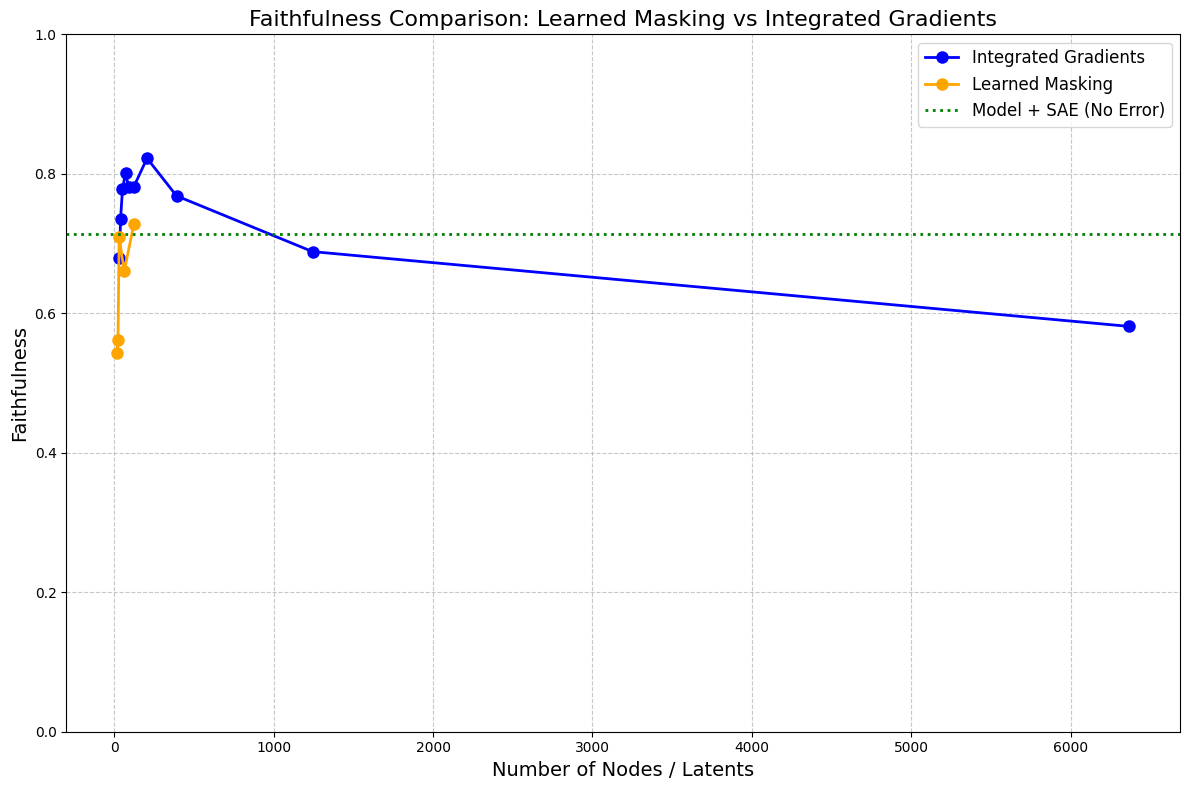

In [65]:
import matplotlib.pyplot as plt
import json
thresholds = []
modify_fn=lambda x: x**2
# thresholds = []
# modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
# thresholds
nnodes = []
faithfulness = []
for i in thresholds:
    sparsity_multiplier = i
    bdir = f"masks/{dropdown}/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])


# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, normalized_faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Learned Masking', color='orange')

plt.axhline(y=avg_logit_diff/avg_model_diff, color='green', linestyle='dotted', linewidth=2, label='Model + SAE (No Error)')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Learned Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)
plt.ylim(0, 1)
# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## SFC-style completeness

In [66]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)

def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch,
        return_type="logits",
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

model_logit_diff = 0
with torch.no_grad():
    for i in range(10):
        batch_model_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        model_logit_diff += batch_model_logit_diff
    model_logit_diff = (model_logit_diff / 10)
    cleanup_cuda()
print("Logit Diff:", model_logit_diff)

# Load masks before inference or further training
sparsity_multiplier = 0.04474285714285713
path = f"masks/{dropdown}"
for idx, sae in enumerate(saes):
    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{idx}.pt"
    state_dict = torch.load(mask_path)
    sae.mask.load_state_dict(state_dict)
    print(f"Loaded mask for SAE {idx} from {mask_path}")

circuit_logit_diff = 0
with torch.no_grad():
    for i in range(10):
        batch_circuit_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        circuit_logit_diff += batch_circuit_logit_diff
        cleanup_cuda()
    circuit_logit_diff = (circuit_logit_diff / 10)
print("Logit Diff:", circuit_logit_diff)

import torch

# Number of elements to remove from the last dimension
num_remove = 5

# Number of batches to process
num_batches = 3  # Adjust this as needed
batch_size = 16  # Batch size for processing

# Remove random subsets of the mask along the [-1] dimension
def get_indices_to_remove(mask, num_remove):
    active_indices = (mask > 0).nonzero(as_tuple=True)[-1]  # Get indices of active elements in the last dimension
    if len(active_indices) < num_remove:
        raise ValueError("Not enough active elements to remove.")
    indices_to_remove = active_indices[torch.randperm(len(active_indices))[:num_remove]].to(mask.device)  # Move to the same device
    return indices_to_remove

def apply_subset_removal(mask, indices_to_remove):
    indices_to_remove = indices_to_remove.to(mask.device)  # Ensure indices are on the same device
    modified_mask = mask.clone()
    modified_mask.index_fill_(-1, indices_to_remove, -1.9455)  # Set selected elements to 0
    return modified_mask

Logit Diff: 2.1952818036079407
Loaded mask for SAE 0 from masks/sva/rc/logit_diff_0.04474285714285713_run/sae_mask_0.pt
Loaded mask for SAE 1 from masks/sva/rc/logit_diff_0.04474285714285713_run/sae_mask_1.pt
Loaded mask for SAE 2 from masks/sva/rc/logit_diff_0.04474285714285713_run/sae_mask_2.pt
Loaded mask for SAE 3 from masks/sva/rc/logit_diff_0.04474285714285713_run/sae_mask_3.pt
Logit Diff: 2.505413055419922


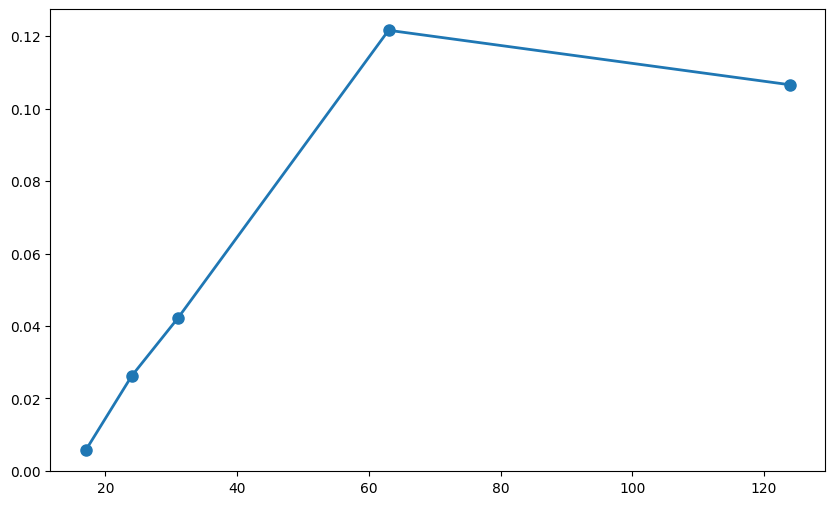

In [67]:
def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch,
        return_type="logits",
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

thresholds = []
mask_paths = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/{dropdown}/logit_diff_{str(sparsity_multiplier)}_run/"
    mask_paths.append(bdir)

batch_idx = -1
nnodes = []
completeness = []
for mask_path in mask_paths:
    mask_dict = {}
    indices_rem_list_full = []
    total_density = 0
    for ind, sae in enumerate(saes):
        bimask_path = f"{mask_path}/sae_mask_{ind}.pt"
        state_dict = torch.load(bimask_path)
        sae.mask.load_state_dict(state_dict)
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()
        total_density += (sae.mask.mask > 0).sum().item()
        indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
        sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
    logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
    nnodes.append(total_density)
    completeness.append(logit_diff/avg_model_diff)

plt.figure(figsize=(10, 6))
plt.plot(nnodes, completeness, marker='o', linestyle='-', linewidth=2, markersize=8)

tensor(-0.0289, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0252, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.3828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.3847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.1764, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2239, device='cuda:0', grad_fn=<MeanBackward0>)


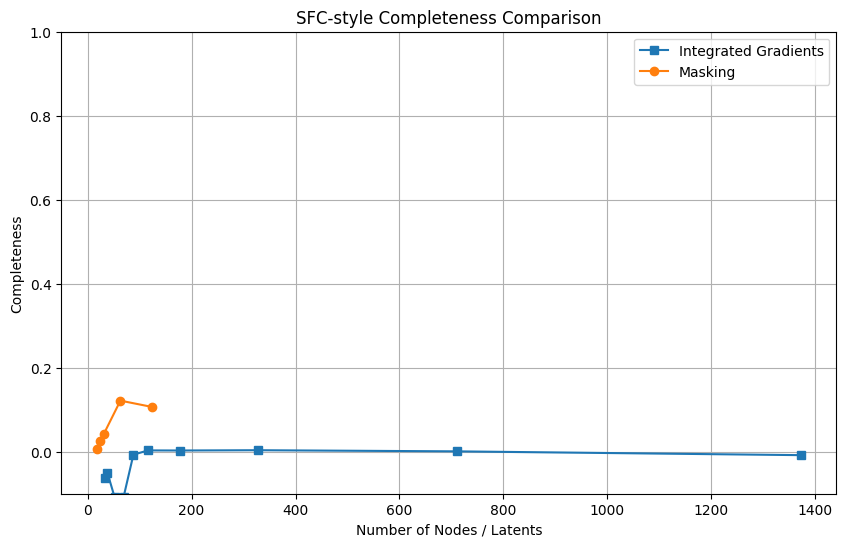

In [68]:
thresholds = []
start_threshold, end_threshold = 0.0005, 0.05
n_runs = 10
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold

mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )

def produce_ig_binary_masks_complement(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        complement_mask = 1.0 - mask
        hook_points.append(hook_point)
        masks.append(complement_mask)

    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

ig_completeness = []
ig_nnodes = []
for threshold in thresholds:
    complement_mask = produce_ig_binary_masks_complement(threshold=threshold)
    mask = produce_ig_binary_masks(threshold=threshold)
    num_latents = mask.get_num_latents()
    ig_nnodes.append(num_latents)
    # break
    ig_logits = model.run_with_hooks(
                    clean_tokens[-1],
                    return_type="logits",
                    fwd_hooks=build_hooks_list(clean_tokens[-1], circuit_mask=complement_mask, mean_mask=True)
                    )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    del ig_logits
    cleanup_cuda()
    print(ld)
    ig_completeness.append(ld.item()/avg_model_diff)

plt.figure(figsize=(10, 6))

plt.plot(ig_nnodes, ig_completeness, marker='s', label="Integrated Gradients")

# First plot: Label masking
plt.plot(nnodes, completeness, marker='o', label="Masking")

# Adding labels and title
plt.xlabel("Number of Nodes / Latents")
plt.ylabel("Completeness")
plt.title("SFC-style Completeness Comparison")
plt.legend()
plt.grid(True)
plt.ylim(-0.1,1)
# Show the plot
plt.show()

## IOI-style completeness

[{'knockout_indices': [tensor([552], device='cuda:0'), tensor([6447, 7096], device='cuda:0'), tensor([ 8846,  2825, 15844], device='cuda:0'), tensor([ 3501,  7231,  2344,   814, 14108,  5382], device='cuda:0')]}, {'knockout_indices': [tensor([3571, 6708], device='cuda:0'), tensor([7931, 6356], device='cuda:0'), tensor([ 2875, 15879,  2340,  8243], device='cuda:0'), tensor([2453, 6698, 1248, 2009, 5360], device='cuda:0')]}, {'knockout_indices': [tensor([11324, 10272], device='cuda:0'), tensor([11377], device='cuda:0'), tensor([ 6768,  5807,  1434, 11870], device='cuda:0'), tensor([ 2722, 11772, 13469,  6166], device='cuda:0')]}, {'knockout_indices': [tensor([1171, 3432], device='cuda:0'), tensor([7309, 1274], device='cuda:0'), tensor([10721, 14828, 12397, 14836,  9326,  4871], device='cuda:0'), tensor([5070], device='cuda:0')]}, {'knockout_indices': [tensor([10873], device='cuda:0'), tensor([13689,  9889], device='cuda:0'), tensor([ 2411, 12116, 11879, 14016,  2142, 12533], device='cuda

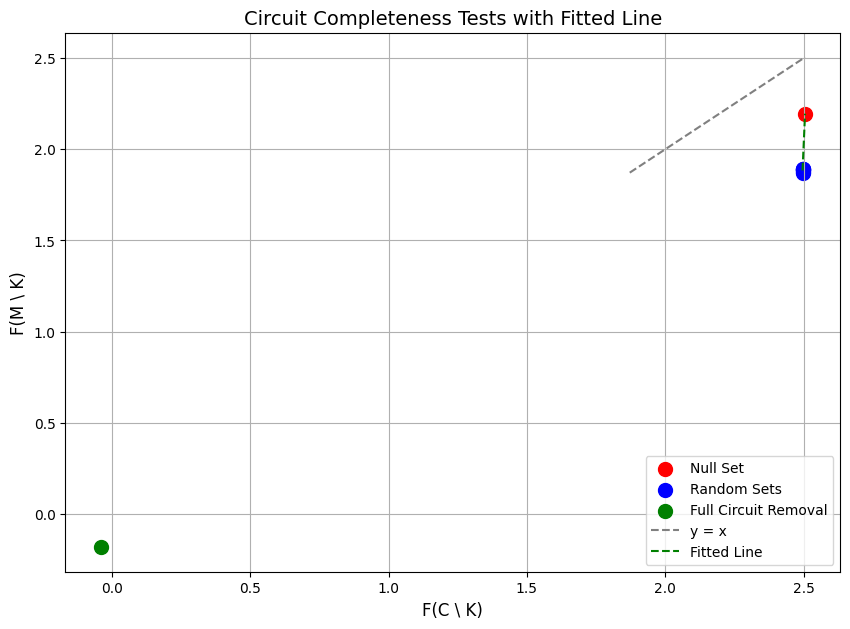

FileNotFoundError: [Errno 2] No such file or directory: 'masks/sva/rc/logit_diff_0.0026368316831683167_run/sae_mask_0.pt'

In [69]:
random_k_results = []
for i in range(7):
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Calculate random num_remove as approximately half the length of the mask
        mask_length = len(mask_dict[sae.cfg.hook_name])
        num_remove = random.randint(max(1, mask_length // 2 - int(mask_length*0.5)), mask_length // 2 + int(mask_length*0.5))
        indices_rem_list.append(get_indices_to_remove(sae.mask.mask.data, num_remove))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)

# Evaluate F(C \ K) and F(M \ K) for N batches
num_batches = 3
for rand_ind, k_results in enumerate(random_k_results):
    for case in ['circuit', 'model']:
        total_knock_logit_diff = 0.0
        for batch_idx in range(num_batches):
            sparsity_multiplier = 0.04474285714285713
            path = f"masks/{dropdown}"
            with torch.no_grad():
                for ind, sae in enumerate(saes):
                    if case == 'circuit':
                        mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                        state_dict = torch.load(mask_path)
                        sae.mask.load_state_dict(state_dict)
                    else:
                        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                    sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, k_results['knockout_indices'][ind]).to(device)
                logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
                total_knock_logit_diff += logit_diff
                cleanup_cuda()
        # Average logit difference for the case
        avg_knock_logit_diff = total_knock_logit_diff / num_batches
        if case == 'circuit':
            print(f"Random set {rand_ind}, F(C \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_C_K'] = avg_knock_logit_diff
        else:
            print(f"Random set {rand_ind}, F(M \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_M_K'] = avg_knock_logit_diff

indices_rem_list_full = []
for ind, sae in enumerate(saes):
    # Get indices to remove based on the original mask
    indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
indices_rem_list_full

for case in ['circuit', 'model']:
    total_knock_logit_diff = 0.0
    for batch_idx in range(num_batches):
        sparsity_multiplier = 0.04474285714285713
        path = f"masks/{dropdown}"
        with torch.no_grad():
            for ind, sae in enumerate(saes):
                if case == 'circuit':
                    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                    state_dict = torch.load(mask_path)
                    sae.mask.load_state_dict(state_dict)
                else:
                    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
            logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
            total_knock_logit_diff += logit_diff
            cleanup_cuda()
    # Average logit difference for the case
    avg_knock_logit_diff = total_knock_logit_diff / num_batches
    if case == 'circuit':
        print(f"full_circ_knock_circ F(C \ K): {avg_knock_logit_diff}")
        full_circ_knock_circ = avg_knock_logit_diff
    else:
        print(f" full_circ_knock_model F(M \ K): {avg_knock_logit_diff}")
        full_circ_knock_model = avg_knock_logit_diff

labels = ['Null Set']
for i in range(7):
    labels.append(f"Random Set {i}")
labels.append('Full Circuit Removal')

xy = [(circuit_logit_diff, model_logit_diff)]
for rand_ind, k_results in enumerate(random_k_results):
    xy.append((k_results['F_C_K'], k_results['F_M_K']))
xy.append((full_circ_knock_circ, full_circ_knock_model))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Extract x and y values
# Separate the data into two groups
# Separate the data into two groups
null_set_xy = xy[0]
random_sets_xy = xy[1:-1]
full_circ_rem = xy[-1]

# Extract x and y values for linear regression
all_x = [point[0] for point in xy[:-1]]
all_y = [point[1] for point in xy[:-1]]

# Fit a linear regression model
regressor = LinearRegression()
all_x_reshaped = np.array(all_x).reshape(-1, 1)  # Reshape for sklearn
regressor.fit(all_x_reshaped, all_y)

# Generate points for the fitted line
fitted_x = np.linspace(min(all_x), max(all_x), 100)
fitted_y = regressor.predict(fitted_x.reshape(-1, 1))

# Extract x and y values for each group
null_set_x, null_set_y = null_set_xy
random_x = [point[0] for point in random_sets_xy]
random_y = [point[1] for point in random_sets_xy]
full_circ_x, full_circ_y = full_circ_rem
# Plot
plt.figure(figsize=(10, 7))

# Null set
plt.scatter(null_set_x, null_set_y, color='red', label='Null Set', s=100)

# Random sets
plt.scatter(random_x, random_y, color='blue', label='Random Sets', s=100)

# Full circuit removal
plt.scatter(full_circ_x, full_circ_y, color='green', label='Full Circuit Removal', s=100)

# Add reference line y = x
x_line = [min([null_set_x] + random_x + [null_set_y] + random_y), max([null_set_x] + random_x + [null_set_y] + random_y)]
plt.plot(x_line, x_line, linestyle="--", color="gray", label="y = x")

# Add fitted regression line
plt.plot(fitted_x, fitted_y, linestyle="--", color="green", label="Fitted Line")

# Customize plot
plt.title("Circuit Completeness Tests with Fitted Line", fontsize=14)
plt.xlabel("F(C \\ K)", fontsize=12)
plt.ylabel("F(M \\ K)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show plot
plt.show()

sparsity_multiplier = thresholds[2]
bdir = f"masks/{dropdown}/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
sae_masks = []
for i in range(4):
    sae_mask = SparseMask(saes[i].cfg.d_sae, 1.0, seq_len=example_length).to(device)
    sae_mask.load_state_dict(torch.load(f"masks/{dropdown}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{i}.pt"))
    sae_masks.append(sae_mask)

import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(clean_data[1])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = sae_masks[mask_index].mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()
